# Predicting Home Prices in Banglore

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

## Data Load: Load Banglore home prices into a dataframe

In [2]:
df1 = pd.read_csv("Bengaluru_House_Data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df1.shape

(13320, 9)

In [4]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [5]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [6]:
df1['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

### Drop features that are not required to build our model 

In [7]:
df2 = df1.drop(['area_type', 'society', 'balcony', 'availability'], axis='columns')
df2.shape

(13320, 5)

In [8]:
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


## Data Cleaning: Handle NA values

In [9]:
df2.isna().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [10]:
df3 = df2.dropna()
df3.isna().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [11]:
df3.shape

(13246, 5)

## Feature Engineering

#### Add new feature(integer) for bhk (Bedrooms Hall Kitchen)

In [12]:
df3['bhk'] = df3['size'].apply(lambda x:int(x.split(' ')[0]))  #this will split value into two and return the value which is on index 0
df3.bhk.unique()

C:\Users\mansh\AppData\Local\Temp\ipykernel_9968\4230616910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x:int(x.split(' ')[0]))  #this will split value into two and return the value which is on index 0


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

#### Explore total_sqft feature

In [13]:
df3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [14]:
def is_float(x):
    try:
        float(x)    # try to covert all values into float
    except:
        return False      # the values which is in range
    return True

In [15]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple

In [16]:
def convert_sqft_to_num(x):
    tokens = x.split('-')         # split the range values into two values
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2     # this will return avg of these two values
    try:
        return float(x)    # this will return the coverted avg value into float 
    except:
        return None

In [17]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


#### For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850

In [18]:
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [19]:
(2100+2850)/2

2475.0

## Feature Engineering

#### Add new feature called price per square feet

In [20]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']  # a new column created name price_per_sqft
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [21]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [22]:
df5.to_csv('bhp.csv', index=False)  # exported to csv file

#### Examine location which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [23]:
len(df5.location.unique())  # no. of unique locations

1298

In [24]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False) # this counts the no. of locations and arrange in descending order
location_stats

Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: location, Length: 1287, dtype: int64

In [25]:
location_stats.values.sum()    # sum of all the values of locations

13200

In [26]:
len(location_stats[location_stats>10])   # location which has values greater than 10

240

In [27]:
len(location_stats)

1287

In [28]:
len(location_stats[location_stats<=10])    # location which has values less than or equal to 10

1047

## Dimensionality Reduction

#### Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [29]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10     # location which has values less than or equal to 10

BTM 1st Stage                10
Gunjur Palya                 10
Nagappa Reddy Layout         10
Sector 1 HSR Layout          10
Thyagaraja Nagar             10
                             ..
Rajanna Layout                1
Subramanyanagar               1
Lakshmipura Vidyaanyapura     1
Malur Hosur Road              1
Abshot Layout                 1
Name: location, Length: 1047, dtype: int64

In [30]:
len(df5.location.unique())

1287

In [31]:
# if value of location is less than or equal to 10 then it will be given value "other"
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

241

In [32]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


## Outlier Removal Using Business Logic

#### As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

In [33]:
df5[df5.total_sqft/df5.bhk<300].head()    # this gives total_sqft per bhk which is less than 300

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


#### Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely

In [34]:
df5.shape

(13200, 7)

In [35]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]   # this will remove total_sqft per bhk which is less than 300
df6.shape

(12456, 7)

## Outlier Removal Using Standard Deviation and Mean

In [36]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

#### Here we find that min price per sqft is 267 rs/sqft whereas max is 176470, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [37]:
def remove_pps_outliers(df):  # taking df as input
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):   # grouping them by location and per location we get subdf
        m = np.mean(subdf.price_per_sqft)    # for each subdf calculating mean
        st = np.std(subdf.price_per_sqft)    # for each subdf calculating standard deviation
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]  # filtering all those data points which are beyond std which means anything above (m-st) and below (m-st). Keep it in reduced_df.
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)    # keep on appending those df per location.
    return df_out    # this will give out df 
df7 = remove_pps_outliers(df6)
df7.shape

(10242, 7)

####  Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

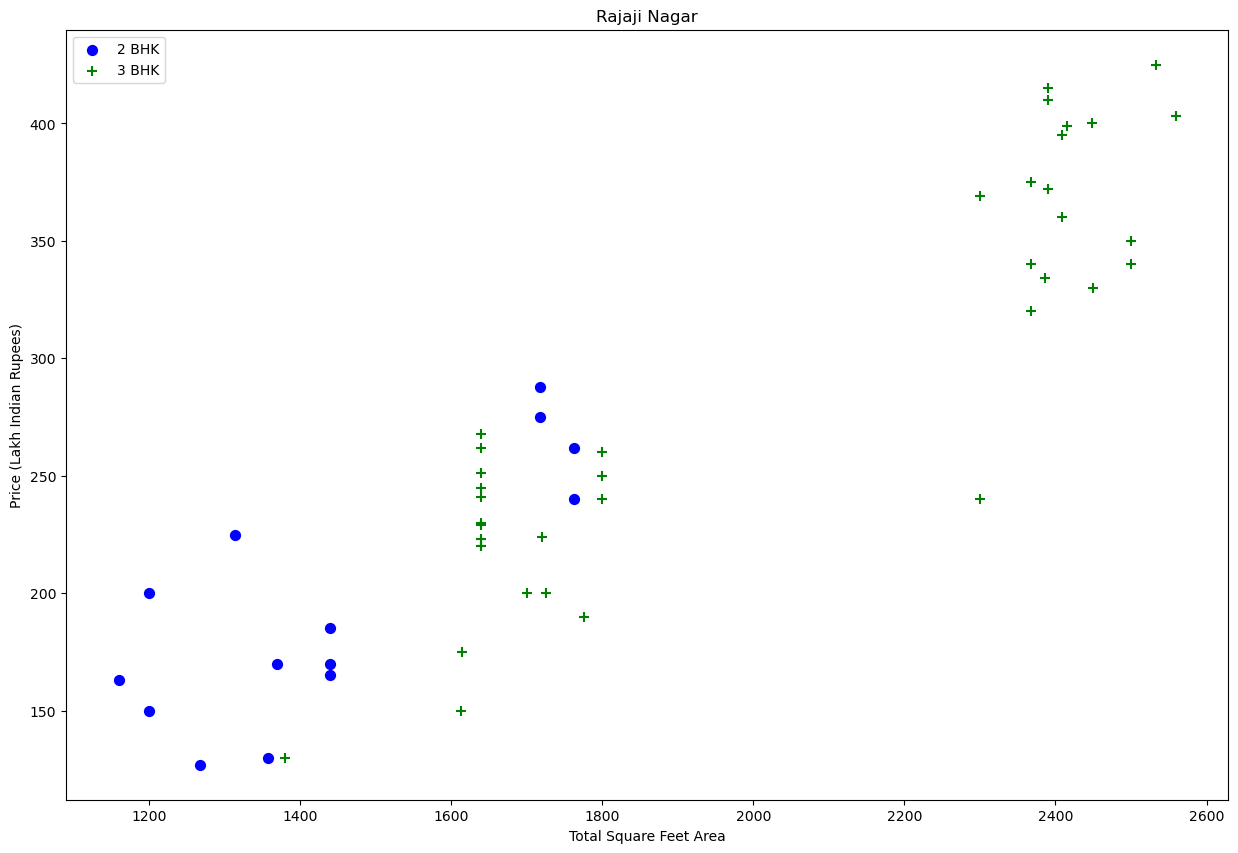

In [38]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

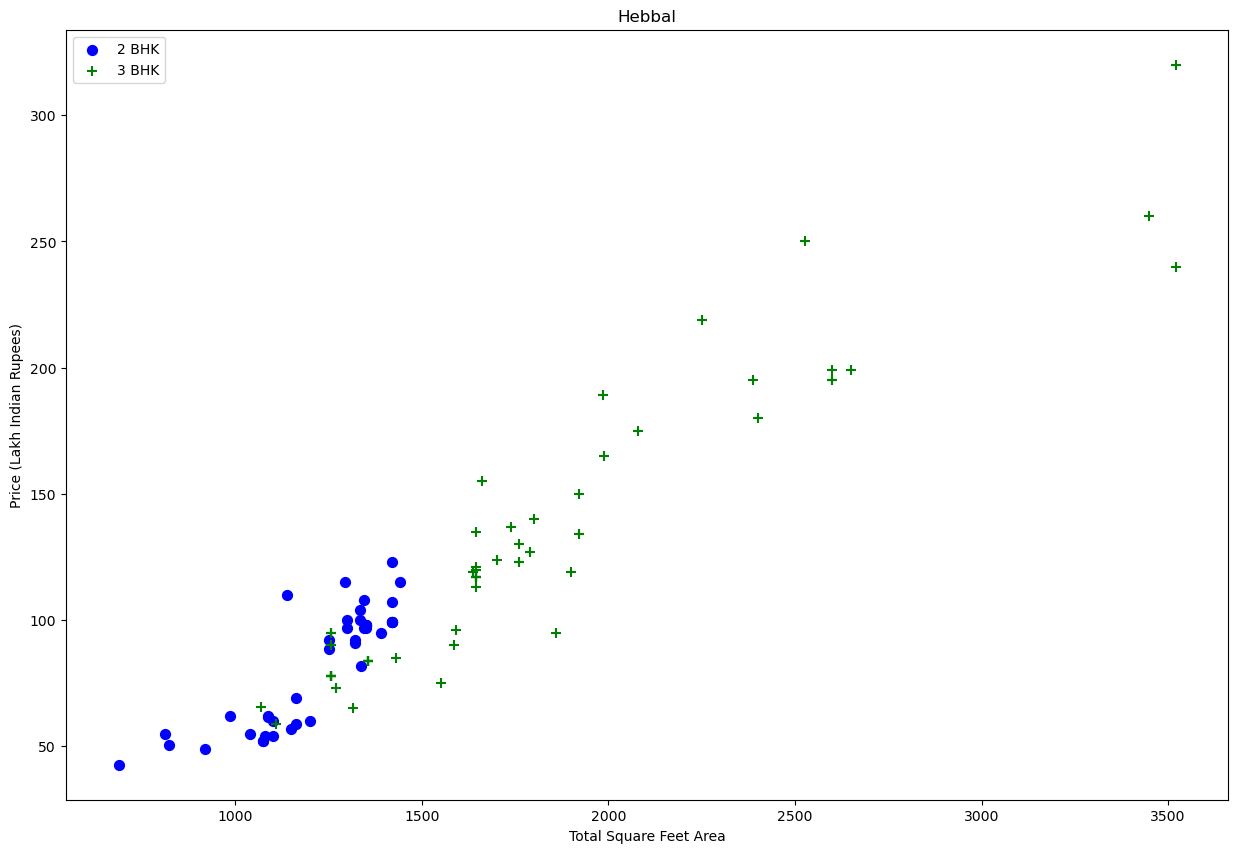

In [39]:
plot_scatter_chart(df7, "Hebbal")

####   We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.

{
    '1' : {
    
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    
    '2' : {
    
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}


#### Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [40]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'): # grouping df by location
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):  # for every location creating a new df based on bhk and per bhk df computing mean, std and count
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        # trying to exclude those data points whose values of price_per_sqft is less than the mean of the previous bhk 
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7317, 7)

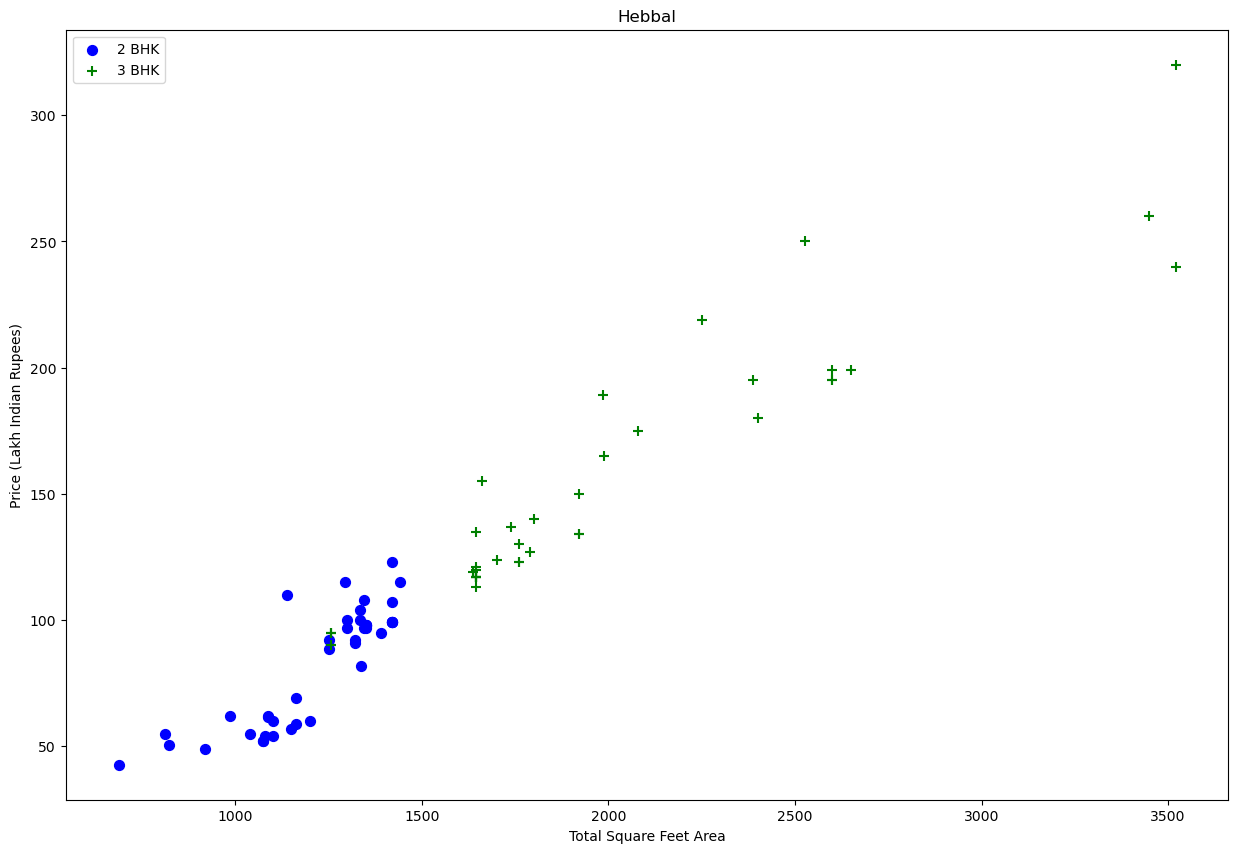

In [41]:
plot_scatter_chart(df8,"Hebbal")

Text(0, 0.5, 'Count')

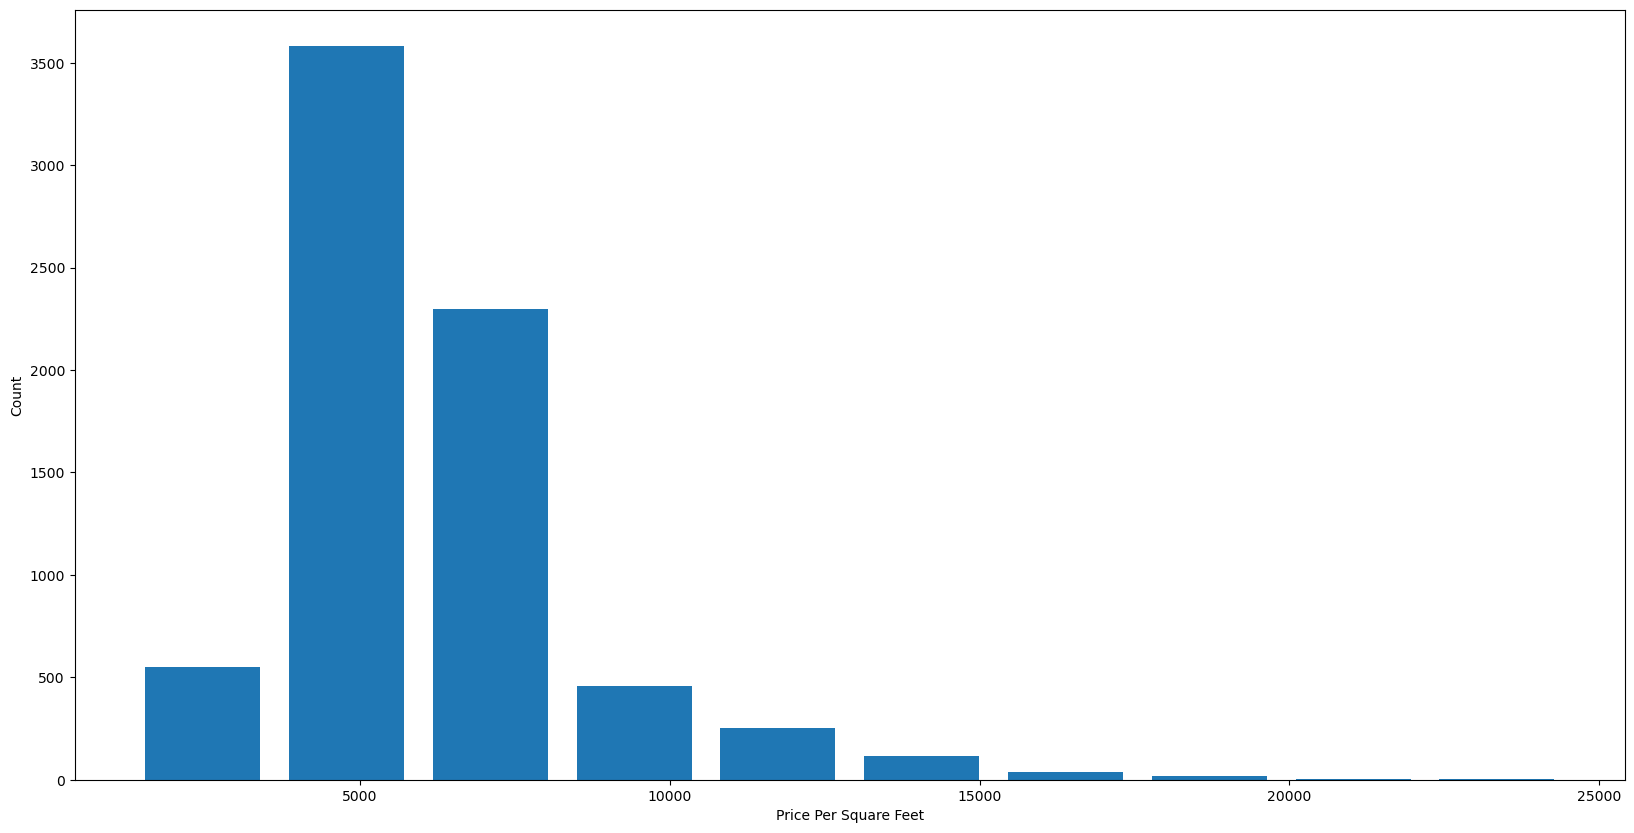

In [42]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft, rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

## Outlier Removal Using Bathrooms Feature

In [43]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

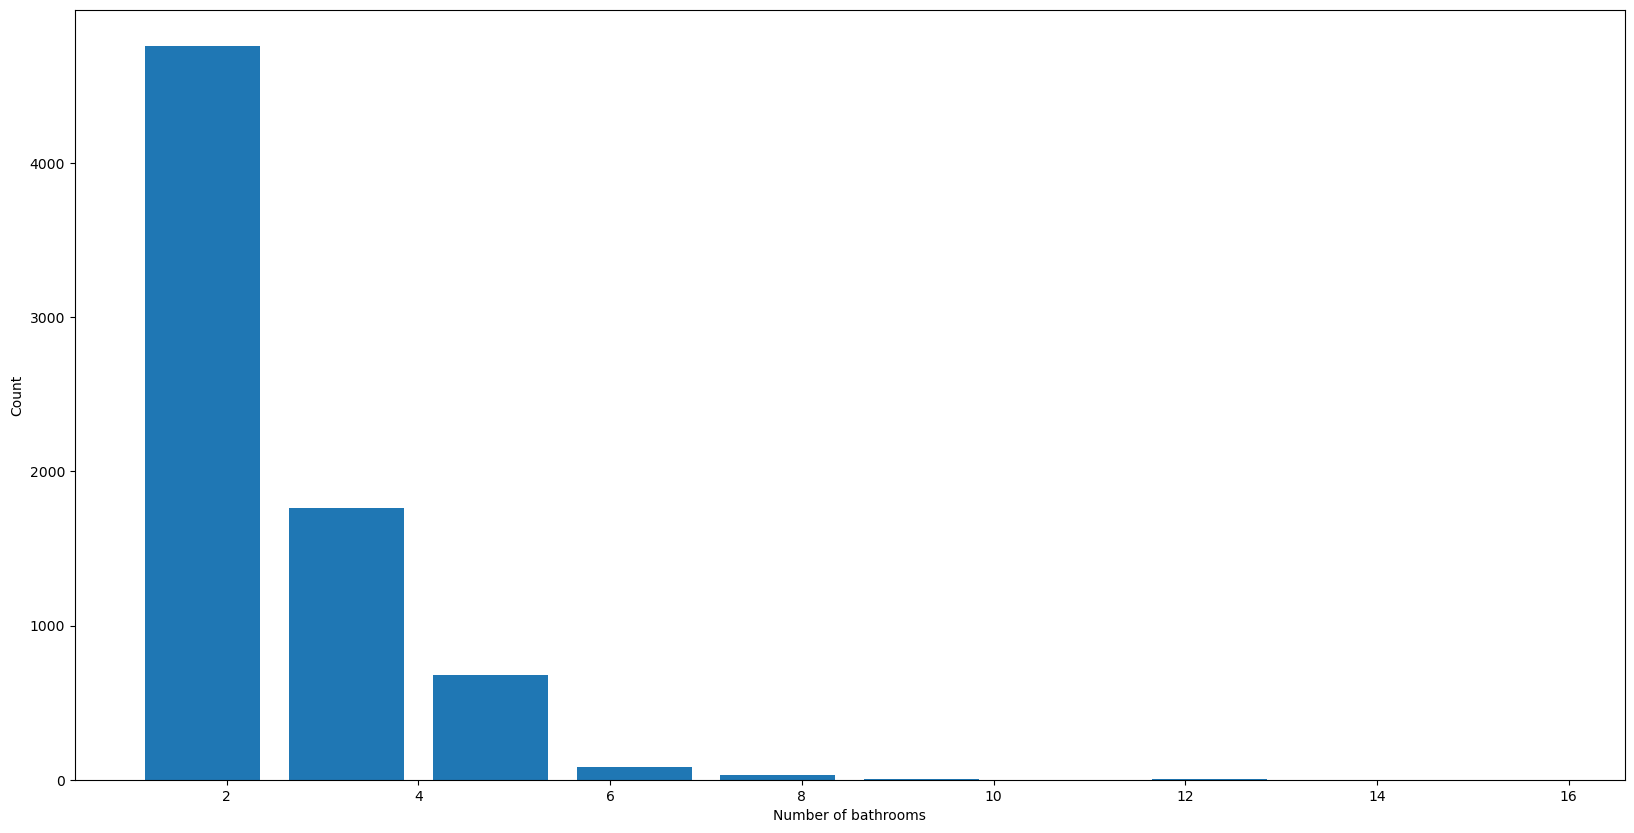

In [44]:
plt.hist(df8.bath, rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [45]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


#### It unusual to have 2 more bathrooms than number of bedrooms in a home

In [46]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


#### Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed

In [47]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7239, 7)

In [48]:
df9.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


In [49]:
df10 = df9.drop(['size', 'price_per_sqft'], axis='columns')
df10.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


## Use One Hot Encoding For Location

In [50]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
df11 = pd.concat([df10, dummies.drop('other', axis='columns')], axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
df12 = df11.drop('location', axis='columns')
df12.head(3)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Build a Model Now...

In [53]:
df12.shape

(7239, 244)

In [54]:
x = df12.drop(['price'], axis='columns')
x.head(3)

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
x.shape

(7239, 243)

In [56]:
y = df12.price
y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [57]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

In [58]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(x_train, y_train)
lr_clf.score(x_test, y_test)

0.8629132245229525

## Use K Fold Cross validation to measure accuracy of our LinearRegression model 

In [59]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), x, y, cv=cv)

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502])

#### We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose

## Find best model using GridSearchCV

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

In [61]:
def find_best_model_using_gridsearchcv(x,y):
    algos = {
        'linear_regression' : {
            'model' : LinearRegression(),
            'params' : {
                'normalize' : [True, False]
            }
        },
        'lasso' : {
            'model' : Lasso(),
            'params' : {
                'alpha' : [1,2],
                'selection' : ['random', 'cyclic']
            }
        },
        'decision_tree' : {
            'model' : DecisionTreeRegressor(),
            'params' : {
                'criterion' : ['mse', 'friedman_mse'],
                'splitter' : ['best', 'random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(x,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])


In [62]:
find_best_model_using_gridsearchcv(x,y)

C:\Users\mansh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\mansh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model =

,model,best_score,best_params
0,linear_regression,0.847796,{'normalize': False}
1,lasso,0.726768,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.715530,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


Based on above results we can say that LinearRegression gives the best score. Hence we will use that.

In [63]:
x.columns

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=243)

### Test the model for few properties

In [64]:
def predict_price(location, sqft, bath, bhk):
    loc_index = np.where(x.columns==location)[0][0]  # this will give the location index i.e. column index of that given location
    
    x_ = np.zeros(len(x.columns))   # creating an array x_
    x_[0] = sqft
    x_[1] = bath
    x_[2] = bhk
    if loc_index >=0 :
        x_[loc_index] = 1
        
    return lr_clf.predict([x_])[0] # the output is in the form of array so we take only 1st element of this array

In [65]:
predict_price('1st Phase JP Nagar', 1000, 2, 2)

C:\Users\mansh\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


83.86570258333366

In [66]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

C:\Users\mansh\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


86.08062285008035

In [67]:
predict_price('Indira Nagar',1000, 2, 2)

C:\Users\mansh\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


193.31197733179067

In [68]:
predict_price('Indira Nagar',1000, 3, 3)

C:\Users\mansh\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


195.5268975985374

## Export the tested model to a pickle file 

In [69]:
import pickle
with open('banglore_home_prices_model.pickle', 'wb') as f:
    pickle.dump(lr_clf, f)

## Export location and column information to a file that will be useful later on in our prediction application 

In [70]:
import json 
columns = {
    'data_columns' : [col.lower() for col in x.columns]
}
with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))